In [ ]:
#기본 IMPORT
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import math
import os
import random


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision.utils import save_image
from torch.autograd import Variable

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE

#TensorBoard 사용하기
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
# 출력 줄수 제한 없애기
from tqdm import tqdm


In [ ]:
# Device 및 기본 설정 + 데이터셋 받아오기(MNIST)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 10
TEMPERATURE = 5
ALPHA=0.5
LEARNING_RATE=0.01

---
---
## TEACHER MODEL 
---
---

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
#Label을 사용하려면 Shuffle을 False로 해줘야 한다.
train_dataset = datasets.MNIST(root='data/MNIST', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data/MNIST',train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=4, pin_memory=True )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=4, pin_memory=True)

for (X_train, y_train) in train_loader:
    pass

teacher_network = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
teacher_network.fc = torch.nn.Linear(teacher_network.fc.in_features,10)
teacher_network = teacher_network.to(DEVICE)
teacher_network.eval()

In [ ]:
# 정확도 계산 함수 + Teacher Network 학습 함수
def evaluate_accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():  # 평가에서는 기울기 계산하지 않음
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f'Accuracy on MNIST test set: {accuracy:.2f}%')
    return accuracy

def train_teacher(model, train_loader, optimizer, criterion, epochs, scheduler, save_path="teacher_model.pth"):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        
        # 에포크별 손실 출력
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")
    
    # 모델 파라미터 저장
    torch.save(model.state_dict(), save_path)
    print(f"Model parameters saved to {save_path}")

print('초기 정확도 출력')
evaluate_accuracy(teacher_network, test_loader)

In [ ]:
# Teacher Network에서 MNIST에 대한 사전 학습
optimizer = torch.optim.Adam(teacher_network.parameters(),lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)  # Cosine Annealing 스케줄러
train_teacher(teacher_network, train_loader, optimizer, criterion, EPOCHS,scheduler)
print('학습 이후 정확도 출력:')
evaluate_accuracy(teacher_network,test_loader)

In [ ]:
#Resnet101 - soft label 추출
def get_soft_labels(model, data_loader, temperature):
    soft_labels = []
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, _ in data_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            # 소프트맥스 온도 적용하여 soft label 생성
            soft_outputs = F.softmax(outputs / temperature, dim=1)
            soft_labels.append(soft_outputs.cpu())  # soft label 저장
    return torch.cat(soft_labels)

#soft label 추출하기
soft_labels = get_soft_labels(teacher_network,train_loader,TEMPERATURE)
torch.save(soft_labels,f"soft_labels/tem={TEMPERATURE}.pt")
#받아올 때에는 soft_labels = torch.load(f'tem=TEM={TEMPERATURE}.pt').to(DEVICE)
print(soft_labels.shape)

In [ ]:
# 첫 번째 배치에 대한 soft labels 확인
for images, _ in train_loader:
    images = images.to(DEVICE)
    outputs = teacher_network(images)
    soft_outputs = F.softmax(outputs / TEMPERATURE, dim=1)
    print("Soft Labels (first batch):", soft_outputs[0].cpu().detach().numpy())  # 첫 번째 샘플의 soft labels 출력
    break

In [ ]:
#soft label 정확도 뽑아보기
soft_labels = torch.load(f'soft_labels/tem={TEMPERATURE}.pt').to(DEVICE)
def calculate_soft_label_accuracy(soft_labels, hard_labels):
    # soft_labels에서 가장 높은 확률을 가진 클래스를 예측 클래스로 선택
    predicted_classes = soft_labels.argmax(dim=1)
    print("predict : ", predicted_classes.shape)
    print("hard_label : ", hard_labels.shape)

    # 예측 클래스와 실제 레이블(hard_labels) 비교
    correct_predictions = (predicted_classes == hard_labels).sum().item()
    accuracy = 100. * correct_predictions / len(hard_labels)
    
    print(f'Soft Labels Accuracy: {accuracy:.2f}%')
    
    # 히스토그램 출력
    plt.hist(predicted_classes.cpu().numpy(), bins=10, range=(0, 9), color='skyblue', edgecolor='black')
    plt.title("Distribution of Predicted Classes")
    plt.xlabel("Predicted Class")
    plt.ylabel("Frequency")
    plt.xticks(range(10))  # 0~9 범위의 클래스 레이블 설정
    plt.show()
    
    return accuracy
# 데이터 로더에서 실제 레이블(hard_labels) 수집
all_hard_labels = []
for _, labels in train_loader:
    all_hard_labels.append(labels)
all_hard_labels = torch.cat(all_hard_labels).to(DEVICE)  # 실제 레이블을 DEVICE에 맞춤

# soft_labels의 정확도 계산
soft_label_accuracy = calculate_soft_label_accuracy(soft_labels, all_hard_labels)


---
---
## Student Model + Distillaion
---
---

In [ ]:
# Dataset 받아오기
# soft label 추출용
#transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])
# 그냥사용용
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='data/MNIST', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data/MNIST', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for (X_train, y_train) in train_loader:
    pass  # 데이터 한 배치만 가져오기

# pltsize = 1
# plt.figure(figsize=(10 * pltsize, pltsize));

# for i in range(10):
#     plt.subplot(1, 10, i + 1)  # plot.subplot(rows, columns, index);
#     plt.axis('off');
#     plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r");
#     plt.title('Class: ' + str(y_train[i].item()));

# plt.show();
# plt.close();

In [ ]:
#Student_Net -> 컨베렐*4
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.gelu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = F.gelu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
#student_model,optimizer,criterion 설정
student_model = Net().to(DEVICE)
optimizer = torch.optim.SGD(student_model.parameters(),lr=0.01,momentum=0.5)
criterion=nn.CrossEntropyLoss()

print(student_model)

In [ ]:
#soft label 정확도 뽑아보기
soft_labels = torch.load(f'soft_labels/tem={TEMPERTATURE}.pt').to(DEVICE)
def calculate_soft_label_accuracy(soft_labels, hard_labels):
    # soft_labels에서 가장 높은 확률을 가진 클래스를 예측 클래스로 선택
    predicted_classes = soft_labels.argmax(dim=1)
    
    # 예측 클래스와 실제 레이블(hard_labels) 비교
    correct_predictions = (predicted_classes == hard_labels).sum().item()
    accuracy = 100. * correct_predictions / len(hard_labels)
    
    print(f'Soft Labels Accuracy: {accuracy:.2f}%')
    return accuracy

# 데이터 로더에서 실제 레이블(hard_labels) 수집
all_hard_labels = []
for _, labels in train_loader:
    all_hard_labels.append(labels)
all_hard_labels = torch.cat(all_hard_labels).to(DEVICE)  # 실제 레이블을 DEVICE에 맞춤

# soft_labels의 정확도 계산
soft_label_accuracy = calculate_soft_label_accuracy(soft_labels, all_hard_labels)


In [ ]:
#Distillation Loss 정의
def distillation_loss(student_logits, teacher_logits, labels, temperature, alpha):
    # Soft target loss (KL Divergence)
    distill_loss = F.kl_div(
        F.log_softmax(student_logits / temperature, dim=1),
        F.softmax(teacher_logits / temperature, dim=1),
        reduction='batchmean'
    ) * (temperature ** 2)
    
    # Hard target loss (CrossEntropy)
    hard_loss = F.cross_entropy(student_logits, labels)
    
    # Combine losses
    return alpha * distill_loss + (1 - alpha) * hard_loss

In [ ]:
#Training용 함수 정의
soft_labels = torch.load(f'soft_labels/tem=={TEMPERATURE}.pt').to(DEVICE)
# Distillation Loss 계산 함수
def distillation_loss(student_logits, soft_labels, temperature, alpha, hard_labels):
    # Soft target loss (KL Divergence)
    distill_loss = F.kl_div(
        F.log_softmax(student_logits / temperature, dim=1),
        soft_labels,
        reduction='batchmean'
    ) * (temperature ** 2)
    
    # Hard target loss (CrossEntropy)
    hard_loss = F.cross_entropy(student_logits, hard_labels)
    
    # Combine losses
    return alpha * distill_loss + (1 - alpha) * hard_loss

# 학습 함수
def train_student(student_model, train_loader, soft_labels, optimizer, temperature, alpha):
    student_model.train()
    
    for batch_idx, (data, hard_labels) in enumerate(train_loader):
        data, hard_labels = data.to(DEVICE), hard_labels.to(DEVICE)
        
        # soft_labels의 해당 배치 슬라이싱
        start_idx = batch_idx * BATCH_SIZE
        end_idx = start_idx + data.size(0)
        target_soft_labels = soft_labels[start_idx:end_idx]

        # Student 모델의 예측
        student_logits = student_model(data)
        
        # Distillation Loss 계산
        loss = distillation_loss(student_logits, target_soft_labels, temperature, alpha, hard_labels)
        
        # 모델 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 테스트 함수
def test(student_model, test_loader):
    student_model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = student_model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Accuracy: {accuracy:.2f}%')

# 전체 학습 루프
for epoch in range(1, EPOCHS + 1):
    train_student(student_model, train_loader, soft_labels, optimizer, TEMPERATURE, ALPHA)
    print(f'Epoch {epoch}:', end=" ")
    test(student_model, test_loader)

In [ ]:
#이 모델 저장해놓기
torch.save(student_model.state_dict(),"student_model_with_resnet_50.pth")

In [ ]:
#Distilled Model 받아오고 시작할 거라면 여기 실행
student_model = Net().to(DEVICE)
student_model.load_state_dict(torch.load("student_model_with_resnet_50.pth"))
student_model.eval()

---
---
## Adversarial Defense Test - Naive Model
---
---


In [ ]:
#Student_Net -> 컨베렐*4
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.gelu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = F.gelu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


#naive_model,optimizer,criterion 설정
naive_model = Net().to(DEVICE)
optimizer = torch.optim.SGD(naive_model.parameters(),lr=0.01,momentum=0.5)
criterion=nn.CrossEntropyLoss()

print(naive_model)

In [ ]:
# 학습 함수
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
# Basic Evaluation Function
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(prediction.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    f1 = f1_score(all_labels, all_predictions, average='macro')
    cm = confusion_matrix(all_labels, all_predictions)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"F1 Score (Macro): {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)


In [ ]:
# Attack 전과 후의 이미지 비교출력코드
def visualize_comparison(original_images_list, perturbed_images_list, original_labels_list, perturbed_preds_list, num_images=16):
    
    # Concatenate all batches into a single tensor and ensure they are detached
    original_images = torch.cat(original_images_list, dim=0)[:num_images].detach()
    perturbed_images = torch.cat(perturbed_images_list, dim=0)[:num_images].detach()
    original_labels = np.concatenate(original_labels_list, axis=0)[:num_images]
    perturbed_preds = np.concatenate(perturbed_preds_list, axis=0)[:num_images]
    
    # Calculate the number of rows needed
    num_cols = 8  # Number of images per row
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed to display all images

    fig, axes = plt.subplots(2 * num_rows, num_cols, figsize=(2 * num_cols, 4 * num_rows))
    
    for i in range(num_images):
        row = (i // num_cols) * 2  # Determine the row index (original and adversarial)
        col = i % num_cols  # Determine the column index
        
        # Original Image
        axes[row, col].imshow(original_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[row, col].set_title(f"Original: {original_labels[i]}")
        axes[row, col].axis('off')
        
        # Adversarial Image
        axes[row + 1, col].imshow(perturbed_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[row + 1, col].set_title(f"Adversarial: {perturbed_preds[i]}")
        axes[row + 1, col].axis('off')
    
    # Hide any unused subplots
    for i in range(num_images, num_cols * num_rows):
        row = (i // num_cols) * 2
        col = i % num_cols
        axes[row, col].axis('off')
        axes[row + 1, col].axis('off')

    plt.tight_layout()
    plt.show()=

In [ ]:
# T-SNE 출력코드
def visualize_tsne(model, test_loader, epsilon, alpha, iterations, visualize=True, num_images=1000, mode='FGSM'):
    model.eval()
    images_list = []
    labels_list = []

    criterion = torch.nn.CrossEntropyLoss()

    for i, (images, labels) in enumerate(test_loader):
        if i * len(images) >= num_images:
            break

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Apply attack based on mode
        if mode == 'FGSM':
            perturbed_images = fgsm_attack_2(model, images, labels, epsilon, criterion)
        elif mode == 'PGD':
            perturbed_images = pgd_attack(model, images, labels, epsilon, alpha, iterations, criterion)
        else:
            raise ValueError("Mode must be either 'FGSM' or 'PGD'")

        # Collect original and perturbed images for TSNE
        with torch.no_grad():
            images_list.append(images)
            labels_list.append(labels)
            images_list.append(perturbed_images)
            labels_list.append(labels)

    # Stack all images and labels
    images_list = torch.cat(images_list, dim=0)
    labels_list = torch.cat(labels_list, dim=0).cpu().numpy()  # Move to CPU and convert to numpy

    # Pass images through the model to get the features
    with torch.no_grad():
        features = model(images_list).view(images_list.size(0), -1)

    # Apply TSNE to reduce to 2 dimensions
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features.cpu().numpy())

    # Plot the TSNE visualization
    if visualize:
        # Colors and markers for each class (0-9)
        colors = cm.get_cmap('tab10', 10)  # Using a colormap with 10 colors
        markers = ['o', 's', 'v', '^', '<', '>', 'P', '*', 'X', 'D']  # Different markers for diversity

        plt.figure(figsize=(12, 10))
        for class_idx in range(10):
            # Plot original images
            class_mask = (labels_list[:len(images_list)//2] == class_idx)
            plt.scatter(tsne_features[:len(images_list)//2, 0][class_mask], 
                        tsne_features[:len(images_list)//2, 1][class_mask], 
                        color=colors(class_idx), marker=markers[class_idx], label=f'Original {class_idx}', alpha=0.5)
            
            # Plot perturbed images
            class_mask = (labels_list[len(images_list)//2:] == class_idx)
            plt.scatter(tsne_features[len(images_list)//2:, 0][class_mask], 
                        tsne_features[len(images_list)//2:, 1][class_mask], 
                        color=colors(class_idx), marker=markers[class_idx], label=f'Perturbed {class_idx}', edgecolor='k', alpha=0.5)
        
        # Set the legend to appear in the top right and split into 2 columns
        plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=2)
        plt.title(f'TSNE Visualization - {mode} Attack')
        plt.show()

    return tsne_features, labels_list


In [ ]:
train(naive_model, DEVICE, train_loader, optimizer, criterion, EPOCHS)
evaluate(naive_model,test_loader, criterion)


In [ ]:
# FGSM에 대한 시각화

def fgsm_attack(model, data, target, epsilon):
    # 데이터에 대한 그래디언트 계산을 활성화
    data.requires_grad = True
    
    # 모델의 예측 및 손실 계산
    output = model(data)
    loss = F.cross_entropy(output, target)
    
    # 역전파를 통해 입력 데이터에 대한 그래디언트 계산
    model.zero_grad()
    loss.backward()
    
    # 그래디언트의 부호를 이용해 입력 데이터 조작
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)  # 데이터 값을 [0,1]로 제한
    
    return perturbed_data

def evaluate_fgsm_atack(model, device, test_loader, epsilon):
    model.eval()
    correct = 0
    adv_examples = []

    # 각 테스트 배치에 대해 공격 수행
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        # FGSM 공격 수행
        perturbed_data = fgsm_attack(model, data, target, epsilon)
        
        # 적대적 예제에 대해 모델의 예측 확인
        output = model(perturbed_data)
        pred = output.max(1, keepdim=True)[1]  # 예측된 클래스
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        # 적대적 예제 일부 저장 (원본과 비교 위해)
        if len(adv_examples) < 5:
            adv_ex = perturbed_data[0].detach().cpu().numpy()
            adv_examples.append((target[0].item(), pred[0].item(), adv_ex))
    
    # 공격된 데이터셋의 정확도 계산
    final_acc = correct / len(test_loader.dataset)
    print(f'Epsilon: {epsilon}\tTest Accuracy under attack: {final_acc * 100:.2f}%')
    return final_acc, adv_examples

In [ ]:
# FGSM to Naive_Model : 이거만 바꾸면서 쓰면 됨
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []
examples = []

for epsilon in epsilons:
    acc, ex = evaluate_fgsm_atack(naive_model, DEVICE, test_loader, epsilon)
    accuracies.append(acc)
    examples.append(ex)

# 여러 epsilon 값에 따른 적대적 예제 시각화
plt.figure(figsize=(10, 10))
for i, (epsilon, ex) in enumerate(zip(epsilons, examples)):
    for j in range(len(ex)):
        target, pred, adv_ex = ex[j]
        plt.subplot(len(epsilons), len(examples[0]), i * len(ex) + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilon}", fontsize=14)
        plt.title(f"{target} -> {pred}")
        plt.imshow(adv_ex.squeeze(), cmap="gray")
plt.tight_layout()
plt.show()

In [118]:
def pgd_attack(model, data, target, epsilon, alpha, num_iter):
    # 원본 데이터를 저장하여 나중에 값을 제한하는 데 사용
    original_data = data.clone().detach()
    
    for _ in range(num_iter):
        # 그래디언트 계산을 위해 매 스텝에서 requires_grad 활성화
        data.requires_grad = True

        # 모델의 출력과 손실 계산
        output = model(data)
        loss = F.cross_entropy(output, target)

        # 손실에 대한 그래디언트 계산
        model.zero_grad()
        loss.backward()

        # 입력 데이터 조정
        data_grad = data.grad.data
        data = data + alpha * data_grad.sign()  # 작은 스텝(alpha)만큼 이동
        data = torch.max(torch.min(data, original_data + epsilon), original_data - epsilon)  # epsilon 범위로 제한
        data = torch.clamp(data, 0, 1)  # 입력 범위 유지

        # requires_grad를 비활성화하여 메모리 절약
        data = data.detach()  # 그래디언트를 유지하지 않도록

    return data

def evaluate_pgd_attack(model, device, test_loader, epsilon, alpha, num_iter):
    model.eval()
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        # PGD 공격 수행
        perturbed_data = pgd_attack(model, data, target, epsilon, alpha, num_iter)
        
        # 적대적 예제에 대한 예측 확인
        output = model(perturbed_data)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

        # 적대적 예제 일부 저장 (원본과 비교 위해)
        if len(adv_examples) < 5:
            adv_ex = perturbed_data[0].detach().cpu().numpy()
            adv_examples.append((target[0].item(), pred[0].item(), adv_ex))
    
    # 공격된 데이터셋에 대한 정확도
    final_acc = correct / len(test_loader.dataset)
    print(f"Epsilon: {epsilon}, Alpha: {alpha}, Iterations: {num_iter} - Test Accuracy under PGD attack: {final_acc * 100:.2f}%")
    return final_acc, adv_examples


Epsilon: 0.1, Alpha: 0.01, Iterations: 40 - Test Accuracy under PGD attack: 9.07%
Epsilon: 0.2, Alpha: 0.01, Iterations: 40 - Test Accuracy under PGD attack: 0.00%
Epsilon: 0.3, Alpha: 0.01, Iterations: 40 - Test Accuracy under PGD attack: 0.00%


<Figure size 1200x1200 with 0 Axes>

<Axes: >

([], [])

([], [])

Text(0, 0.5, 'Epsilon: 0.1')

Text(0.5, 1.0, '7 -> 0')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '3 -> 3')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '7 -> 3')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '1 -> 4')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '8 -> 8')

<Axes: >

([], [])

([], [])

Text(0, 0.5, 'Epsilon: 0.2')

Text(0.5, 1.0, '7 -> 0')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '3 -> 9')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '7 -> 3')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '1 -> 4')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '8 -> 3')

<Axes: >

([], [])

([], [])

Text(0, 0.5, 'Epsilon: 0.3')

Text(0.5, 1.0, '7 -> 0')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '3 -> 9')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '7 -> 3')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '1 -> 4')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '8 -> 3')

Text(0.5, 0.98, 'PGD Adversarial Examples with Various Epsilons')

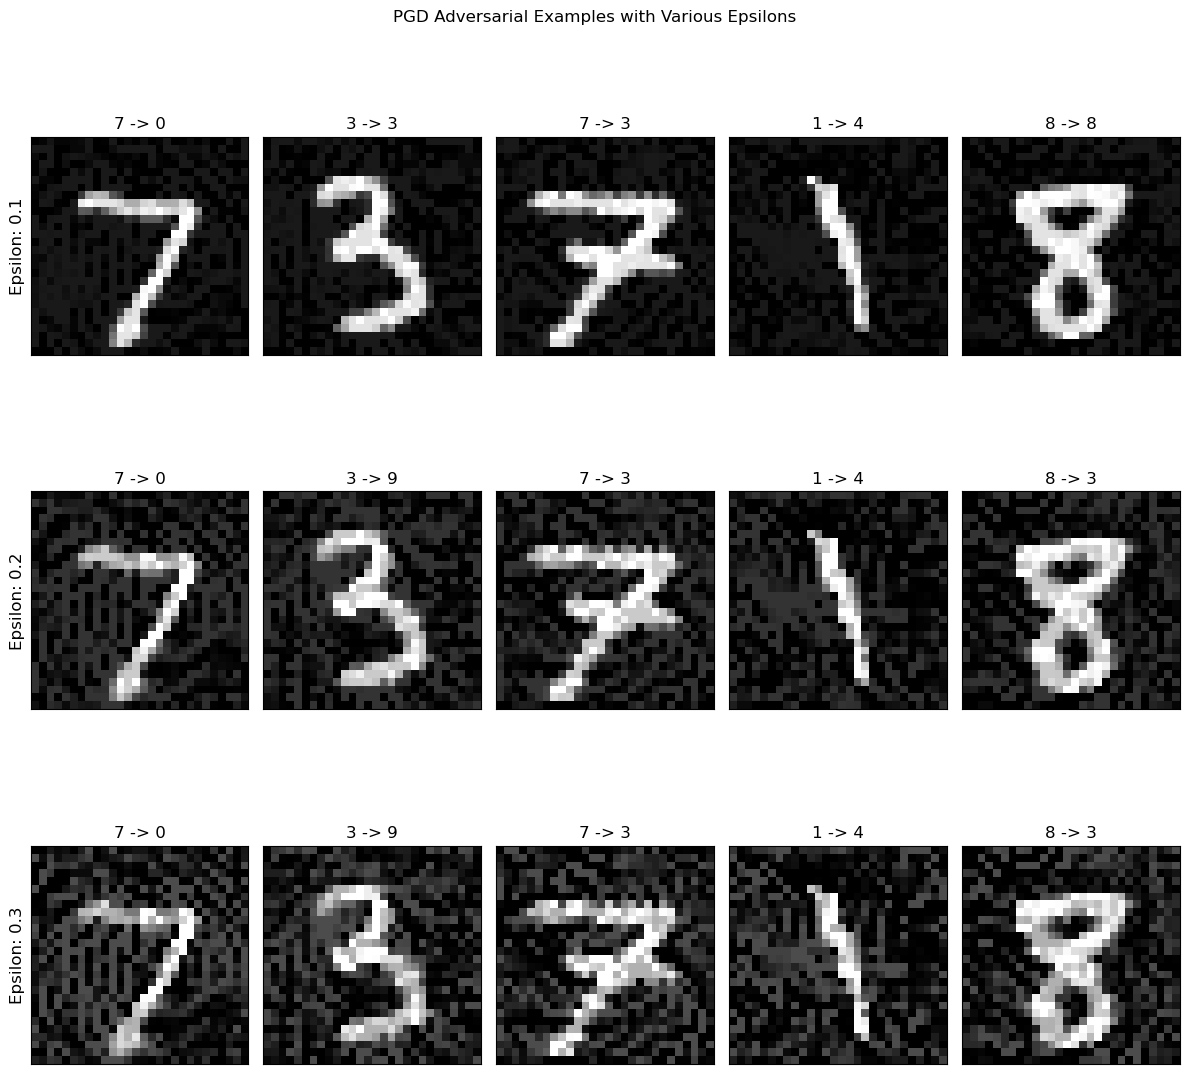

In [ ]:
# PGD to Naive_Model : 이거만 바꾸면서 쓰면 됨
epsilons = [0.1, 0.2, 0.3]    # 여러 epsilon 값 (공격 강도)
alpha = 0.01                  # 스텝 크기 (모든 epsilon에 동일하게 적용)
num_iter = 40                 # 스텝 수 (모든 epsilon에 동일하게 적용)

# 공격 결과를 저장할 리스트 초기화
pgd_accuracies = []
pgd_examples = []

for epsilon in epsilons:
    # 각 epsilon에 대해 PGD 공격 수행 및 모델 정확도 평가
    acc, examples = evaluate_pgd_attack(naive_model, DEVICE, test_loader, epsilon, alpha, num_iter)
    pgd_accuracies.append(acc)
    pgd_examples.append(examples)

# 여러 epsilon 값에 따른 적대적 예제 시각화
plt.figure(figsize=(12, 12))
for i, (epsilon, examples) in enumerate(zip(epsilons, pgd_examples)):
    for j in range(len(examples)):
        target, pred, adv_ex = examples[j]
        plt.subplot(len(epsilons), len(examples), i * len(examples) + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Epsilon: {epsilon}", fontsize=12)
        plt.title(f"{target} -> {pred}")
        plt.imshow(adv_ex.squeeze(), cmap="gray")
plt.suptitle("PGD Adversarial Examples with Various Epsilons")
plt.tight_layout()
plt.show()


In [131]:
# C&W Attack - L2 Norm을 이용한 공격 함수
def cw_l2_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01):
    images = images.to(DEVICE)     
    labels = labels.to(DEVICE)

    # Define f-function
    def f(x):
        outputs = model(x)
        one_hot_labels = torch.eye(len(outputs[0]), device=DEVICE)[labels]

        i, _ = torch.max((1 - one_hot_labels) * outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.bool())
        
        if targeted:
            return torch.clamp(i - j, min=-kappa)
        else:
            return torch.clamp(j - i, min=-kappa)
    
    w = torch.zeros_like(images, requires_grad=True).to(DEVICE)
    optimizer = torch.optim.Adam([w], lr=learning_rate)
    prev = 1e10
    
    for step in range(max_iter):
        a = 1 / 2 * (nn.Tanh()(w) + 1)
        loss1 = nn.MSELoss(reduction='sum')(a, images)
        loss2 = torch.sum(c * f(a))
        cost = loss1 + loss2

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if step % (max_iter // 10) == 0:
            if cost > prev:
                print('Attack Stopped due to CONVERGENCE....')
                return a
            prev = cost

    attack_images = 1 / 2 * (nn.Tanh()(w) + 1)
    return attack_images

# evaluate_cw_attack 함수에 tqdm 추가
def evaluate_cw_attack(model, device, test_loader, c, kappa, max_iter, learning_rate):
    model.eval()
    correct = 0
    adv_examples = []

    for data, target in tqdm(test_loader, desc="Evaluating C&W Attack"):
        data, target = data.to(device), target.to(device)
        
        perturbed_data = cw_l2_attack(model, data, target, c=c, kappa=kappa, max_iter=max_iter, learning_rate=learning_rate)
        
        output = model(perturbed_data)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

        if len(adv_examples) < 5:
            adv_ex = perturbed_data[0].detach().cpu().numpy()
            adv_examples.append((target[0].item(), pred[0].item(), adv_ex))

    final_acc = correct / len(test_loader.dataset)
    print(f"CW Attack - c: {c}, Kappa: {kappa}, Iterations: {max_iter}, Learning Rate: {learning_rate} - Test Accuracy: {final_acc * 100:.2f}%")
    return final_acc, adv_examples


Evaluating C&W Attack: 100%|██████████| 313/313 [07:28<00:00,  1.43s/it]


CW Attack - c: 0.001, Kappa: 1, Iterations: 500, Learning Rate: 0.01 - Test Accuracy: 99.11%


Evaluating C&W Attack: 100%|██████████| 313/313 [07:29<00:00,  1.44s/it]

CW Attack - c: 0.01, Kappa: 1, Iterations: 500, Learning Rate: 0.01 - Test Accuracy: 98.95%


<Figure size 1200x1200 with 0 Axes>

<Axes: >

([], [])

([], [])

Text(0, 0.5, 'c: 0.001')

Text(0.5, 1.0, '7 -> 7')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '3 -> 3')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '7 -> 7')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '1 -> 1')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '8 -> 8')

<Axes: >

([], [])

([], [])

Text(0, 0.5, 'c: 0.01')

Text(0.5, 1.0, '7 -> 7')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '3 -> 3')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '7 -> 7')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '1 -> 1')

<Axes: >

([], [])

([], [])

Text(0.5, 1.0, '8 -> 8')

Text(0.5, 0.98, 'C&W Adversarial Examples with Various c Values')

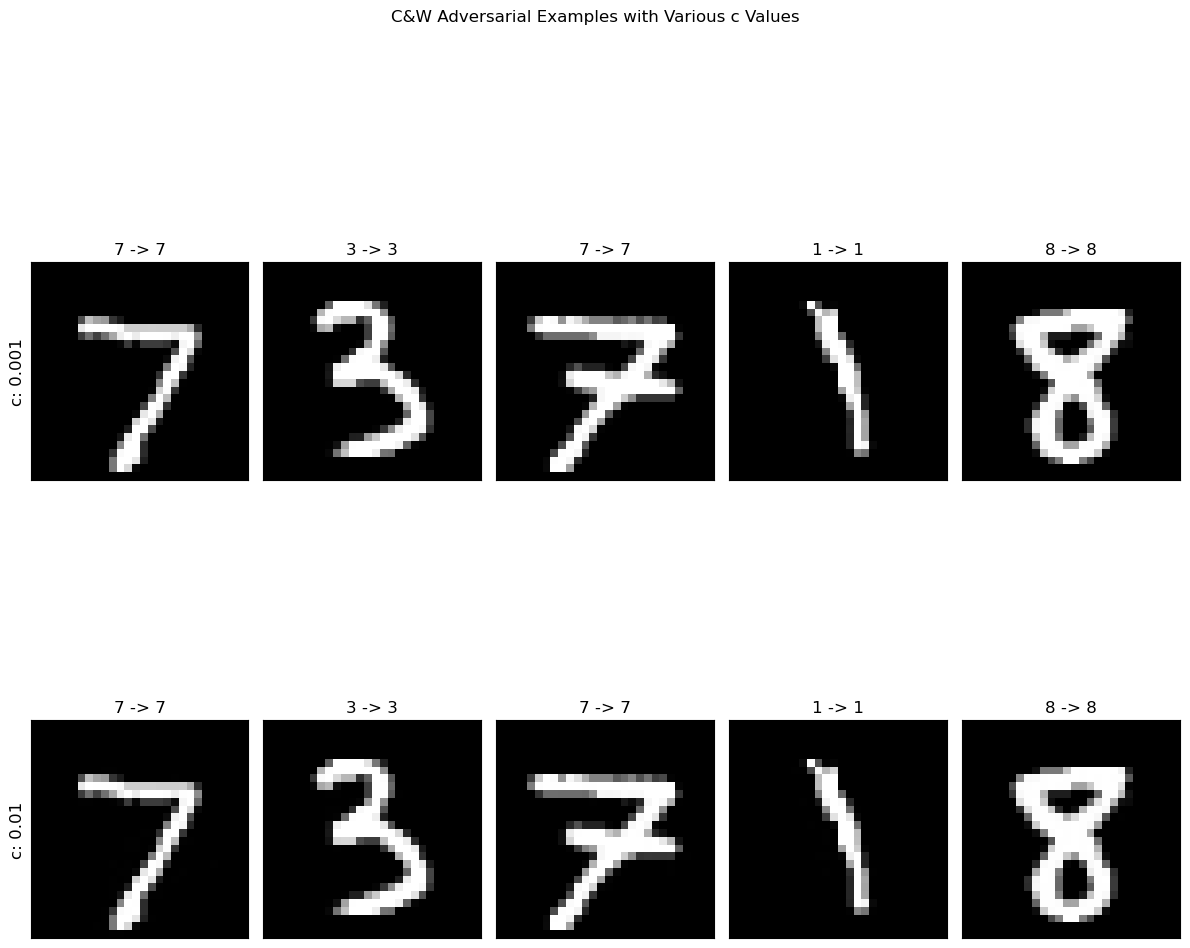

In [135]:
# C&W 공격 설정
c_values = [1e-3,1e-2]  # 여러 c 값 (공격 강도)
kappa = 1                     # confidence 매개변수
max_iter = 500                 # 공격 반복 횟수
learning_rate = 0.01            # 학습률

# 공격 결과를 저장할 리스트 초기화
cw_accuracies = []
cw_examples = []

for c in c_values:
    # 각 c에 대해 C&W 공격 수행 및 모델 정확도 평가
    acc, examples = evaluate_cw_attack(naive_model, DEVICE, test_loader, c, kappa, max_iter, learning_rate)
    cw_accuracies.append(acc)
    cw_examples.append(examples)


# 여러 c 값에 따른 적대적 예제 시각화
plt.figure(figsize=(12, 12))
for i, (c, examples) in enumerate(zip(c_values, cw_examples)):
    for j in range(len(examples)):
        target, pred, adv_ex = examples[j]
        plt.subplot(len(c_values), len(examples), i * len(examples) + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"c: {c}", fontsize=12)
        plt.title(f"{target} -> {pred}")
        plt.imshow(adv_ex.squeeze(), cmap="gray")
plt.suptitle("C&W Adversarial Examples with Various c Values")
plt.tight_layout()
plt.show()

In [138]:
def deepfool_attack(model, image, num_classes=None, overshoot=0.02, max_iter=50):
    """
    DeepFool 공격 함수
    Args:
        model: 공격 대상 모델
        image: 원본 입력 이미지 (단일 샘플)
        num_classes: 모델의 클래스 수 (MNIST의 경우 10, 자동 설정 가능)
        overshoot: 결정 경계를 넘기 위한 여분의 이동량
        max_iter: 최대 반복 횟수
    """
    # 입력 이미지를 복사하고 requires_grad를 True로 설정
    perturbed_image = image.clone().detach().requires_grad_(True).to(DEVICE)
    output = model(perturbed_image).detach()
    
    # 모델의 클래스 수 자동 설정
    if num_classes is None:
        num_classes = output.shape[1]
    
    # 초기 클래스 설정
    current_class = output.argmax().item()
    r_tot = torch.zeros_like(image).to(DEVICE)  # 누적 perturbation
    
    for _ in range(max_iter):
        # 모델의 출력 계산
        output = model(perturbed_image)
        current_class = output.argmax().item()

        # 만약 클래스가 변경되면 반복 종료
        if current_class != output.argmax().item():
            break

        # 각 클래스별 손실의 그래디언트를 계산하여 결정 경계 계산
        gradients = []
        for k in range(num_classes):
            if k == current_class:
                continue
            zero_gradients = torch.zeros_like(output)
            zero_gradients[0, k] = 1
            model.zero_grad()
            output.backward(zero_gradients, retain_graph=True)
            gradients.append(perturbed_image.grad.clone())
            perturbed_image.grad.zero_()
        
        # 결정 경계를 넘는 최소 변화 계산
        w = torch.stack(gradients).squeeze()
        f = output[0][current_class] - output[0][[i for i in range(num_classes) if i != current_class]]
        f = f.detach()
        r_i = torch.abs(f / torch.norm(w, p=2, dim=1)) * w / torch.norm(w, p=2, dim=1).unsqueeze(1)
        r_tot += r_i[torch.argmin(torch.abs(f))]
        
        # 누적 perturbation을 이미지에 적용
        perturbed_image = image + (1 + overshoot) * r_tot
        perturbed_image = torch.clamp(perturbed_image, 0, 1).detach().requires_grad_(True)
    
    return perturbed_image

def evaluate_deepfool_attack(model, device, test_loader, num_classes=10, overshoot=0.02, max_iter=50):
    model.eval()
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        # DeepFool 공격 수행
        perturbed_data = deepfool_attack(model, data, num_classes=num_classes, overshoot=overshoot, max_iter=max_iter)
        
        # 적대적 예제에 대한 모델 예측 확인
        output = model(perturbed_data)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

        # 일부 예제를 저장하여 시각화
        if len(adv_examples) < 5:
            adv_ex = perturbed_data[0].detach().cpu().numpy()
            adv_examples.append((target[0].item(), pred[0].item(), adv_ex))

    # 공격된 데이터셋에 대한 정확도
    final_acc = correct / len(test_loader.dataset)
    print(f"DeepFool Attack - Test Accuracy under attack: {final_acc * 100:.2f}%")
    return final_acc, adv_examples


In [139]:
# DeepFool 공격 수행
deepfool_accuracy, deepfool_examples = evaluate_deepfool_attack(naive_model, DEVICE, test_loader, num_classes=10, overshoot=0.02, max_iter=50)
# DeepFool 적대적 예제 시각화
plt.figure(figsize=(10, 5))
for i, (target, pred, adv_ex) in enumerate(deepfool_examples):
    # 원본 이미지
    plt.subplot(2, 5, i + 1)
    plt.imshow(adv_ex.squeeze(), cmap="gray")
    plt.title(f"{target} -> {pred}")
    plt.axis("off")
plt.suptitle("DeepFool Adversarial Examples")
plt.tight_layout()
plt.show()


IndexError: index 274 is out of bounds for dimension 0 with size 10

---
---
## Adversarial Defense Test - Teacher Model
---
---


In [ ]:
# 입력 이미지를 1채널에서 3채널로 변환하는 transform
transform_for_teacher_model = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 1채널을 3채널로 변환
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화 (선택사항)
])

# MNIST 데이터셋 로드 시 transform 적용
train_dataset_teacher = datasets.MNIST(root='data/MNIST', train=True, download=True, transform=transform_for_teacher_model)
test_dataset_teacher = datasets.MNIST(root='data/MNIST', train=False, transform=transform_for_teacher_model)
train_loader_teacher = torch.utils.data.DataLoader(dataset=train_dataset_teacher, batch_size=32, shuffle=False)
test_loader_teacher = torch.utils.data.DataLoader(dataset=test_dataset_teacher, batch_size=32, shuffle=False)

teacher_model = models.resnet50()
teacher_model.fc = torch.nn.Linear(2048,10)
teacher_model.load_state_dict(torch.load("teacher_model.pth"))
teacher_model=teacher_model.to(DEVICE)
teacher_model.eval()

C:\Users\user\AppData\Local\Temp\ipykernel_26532\1268278181.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("teacher_model.pth"

<All keys matched successfully>

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [149]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []
examples = []

for epsilon in epsilons:
    acc, ex = evaluate_fgsm_atack(teacher_model, DEVICE, test_loader_teacher, epsilon)
    accuracies.append(acc)
    examples.append(ex)

# 여러 epsilon 값에 따른 적대적 예제 시각화
plt.figure(figsize=(10, 10))
for i, (epsilon, ex) in enumerate(zip(epsilons, examples)):
    for j in range(len(ex)):
        target, pred, adv_ex = ex[j]
        plt.subplot(len(epsilons), len(examples[0]), i * len(ex) + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilon}", fontsize=14)
        plt.title(f"{target} -> {pred}")
        plt.imshow(adv_ex.squeeze(), cmap="gray")
plt.tight_layout()
plt.show()
# PGD to Naive_Model : 이거만 바꾸면서 쓰면 됨
epsilons = [0.1, 0.2, 0.3]    # 여러 epsilon 값 (공격 강도)
alpha = 0.01                  # 스텝 크기 (모든 epsilon에 동일하게 적용)
num_iter = 40                 # 스텝 수 (모든 epsilon에 동일하게 적용)

# 공격 결과를 저장할 리스트 초기화
pgd_accuracies = []
pgd_examples = []

for epsilon in epsilons:
    # 각 epsilon에 대해 PGD 공격 수행 및 모델 정확도 평가
    acc, examples = evaluate_pgd_attack(teacher_model, DEVICE, test_loader_teacher, epsilon, alpha, num_iter)
    pgd_accuracies.append(acc)
    pgd_examples.append(examples)

# 여러 epsilon 값에 따른 적대적 예제 시각화
plt.figure(figsize=(12, 12))
for i, (epsilon, examples) in enumerate(zip(epsilons, pgd_examples)):
    for j in range(len(examples)):
        target, pred, adv_ex = examples[j]
        plt.subplot(len(epsilons), len(examples), i * len(examples) + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Epsilon: {epsilon}", fontsize=12)
        plt.title(f"{target} -> {pred}")
        plt.imshow(adv_ex.squeeze(), cmap="gray")
plt.suptitle("PGD Adversarial Examples with Various Epsilons")
plt.tight_layout()
plt.show()

# C&W 공격 설정
c_values = [1e-3,1e-2]  # 여러 c 값 (공격 강도)
kappa = 1                     # confidence 매개변수
max_iter = 500                 # 공격 반복 횟수
learning_rate = 0.01            # 학습률

# 공격 결과를 저장할 리스트 초기화
cw_accuracies = []
cw_examples = []

for c in c_values:
    # 각 c에 대해 C&W 공격 수행 및 모델 정확도 평가
    acc, examples = evaluate_cw_attack(teacher_model, DEVICE, test_loader_teacher, c, kappa, max_iter, learning_rate)
    cw_accuracies.append(acc)
    cw_examples.append(examples)


# 여러 c 값에 따른 적대적 예제 시각화
plt.figure(figsize=(12, 12))
for i, (c, examples) in enumerate(zip(c_values, cw_examples)):
    for j in range(len(examples)):
        target, pred, adv_ex = examples[j]
        plt.subplot(len(c_values), len(examples), i * len(examples) + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"c: {c}", fontsize=12)
        plt.title(f"{target} -> {pred}")
        plt.imshow(adv_ex.squeeze(), cmap="gray")
plt.suptitle("C&W Adversarial Examples with Various c Values")
plt.tight_layout()
plt.show()
# DeepFool 공격 수행
deepfool_accuracy, deepfool_examples = evaluate_deepfool_attack(teacher_model, DEVICE, test_loader_teacher, num_classes=10, overshoot=0.02, max_iter=50)
# DeepFool 적대적 예제 시각화
plt.figure(figsize=(10, 5))
for i, (target, pred, adv_ex) in enumerate(deepfool_examples):
    # 원본 이미지
    plt.subplot(2, 5, i + 1)
    plt.imshow(adv_ex.squeeze(), cmap="gray")
    plt.title(f"{target} -> {pred}")
    plt.axis("off")
plt.suptitle("DeepFool Adversarial Examples")
plt.tight_layout()
plt.show()


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead

---
---
## Adversarial Defense Test - Distilled Model
---
---


In [ ]:
distilled_model = Net().to(DEVICE)
distilled_model.load_state_dict(torch.load("student_model_with_resnet_50.pth"))
distilled_model.eval()

In [ ]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []
examples = []

for epsilon in epsilons:
    acc, ex = evaluate_fgsm_atack(distilled_model, DEVICE, test_loader, epsilon)
    accuracies.append(acc)
    examples.append(ex)

# 여러 epsilon 값에 따른 적대적 예제 시각화
plt.figure(figsize=(10, 10))
for i, (epsilon, ex) in enumerate(zip(epsilons, examples)):
    for j in range(len(ex)):
        target, pred, adv_ex = ex[j]
        plt.subplot(len(epsilons), len(examples[0]), i * len(ex) + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilon}", fontsize=14)
        plt.title(f"{target} -> {pred}")
        plt.imshow(adv_ex.squeeze(), cmap="gray")
plt.tight_layout()
plt.show()
# PGD to Naive_Model : 이거만 바꾸면서 쓰면 됨
epsilons = [0.1, 0.2, 0.3]    # 여러 epsilon 값 (공격 강도)
alpha = 0.01                  # 스텝 크기 (모든 epsilon에 동일하게 적용)
num_iter = 40                 # 스텝 수 (모든 epsilon에 동일하게 적용)

# 공격 결과를 저장할 리스트 초기화
pgd_accuracies = []
pgd_examples = []

for epsilon in epsilons:
    # 각 epsilon에 대해 PGD 공격 수행 및 모델 정확도 평가
    acc, examples = evaluate_pgd_attack(distilled_model, DEVICE, test_loader, epsilon, alpha, num_iter)
    pgd_accuracies.append(acc)
    pgd_examples.append(examples)

# 여러 epsilon 값에 따른 적대적 예제 시각화
plt.figure(figsize=(12, 12))
for i, (epsilon, examples) in enumerate(zip(epsilons, pgd_examples)):
    for j in range(len(examples)):
        target, pred, adv_ex = examples[j]
        plt.subplot(len(epsilons), len(examples), i * len(examples) + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Epsilon: {epsilon}", fontsize=12)
        plt.title(f"{target} -> {pred}")
        plt.imshow(adv_ex.squeeze(), cmap="gray")
plt.suptitle("PGD Adversarial Examples with Various Epsilons")
plt.tight_layout()
plt.show()

# C&W 공격 설정
c_values = [1e-3,1e-2]  # 여러 c 값 (공격 강도)
kappa = 1                     # confidence 매개변수
max_iter = 500                 # 공격 반복 횟수
learning_rate = 0.01            # 학습률

# 공격 결과를 저장할 리스트 초기화
cw_accuracies = []
cw_examples = []

for c in c_values:
    # 각 c에 대해 C&W 공격 수행 및 모델 정확도 평가
    acc, examples = evaluate_cw_attack(distilled_model, DEVICE, test_loader, c, kappa, max_iter, learning_rate)
    cw_accuracies.append(acc)
    cw_examples.append(examples)


# 여러 c 값에 따른 적대적 예제 시각화
plt.figure(figsize=(12, 12))
for i, (c, examples) in enumerate(zip(c_values, cw_examples)):
    for j in range(len(examples)):
        target, pred, adv_ex = examples[j]
        plt.subplot(len(c_values), len(examples), i * len(examples) + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"c: {c}", fontsize=12)
        plt.title(f"{target} -> {pred}")
        plt.imshow(adv_ex.squeeze(), cmap="gray")
plt.suptitle("C&W Adversarial Examples with Various c Values")
plt.tight_layout()
plt.show()
# DeepFool 공격 수행
deepfool_accuracy, deepfool_examples = evaluate_deepfool_attack(distilled_model, DEVICE, test_loader, num_classes=10, overshoot=0.02, max_iter=50)
# DeepFool 적대적 예제 시각화
plt.figure(figsize=(10, 5))
for i, (target, pred, adv_ex) in enumerate(deepfool_examples):
    # 원본 이미지
    plt.subplot(2, 5, i + 1)
    plt.imshow(adv_ex.squeeze(), cmap="gray")
    plt.title(f"{target} -> {pred}")
    plt.axis("off")
plt.suptitle("DeepFool Adversarial Examples")
plt.tight_layout()
plt.show()


---
---
## Defense-GAN
---
---


In [ ]:
# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_size=28, channels=1):
        super(Generator, self).__init__()
        
        self.init_size = img_size // 4  # 초기 이미지 크기 설정
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.model = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.model(out)  # self.model 사용
        return img

# Discriminator 모델 정의 (Critic)
class Discriminator(nn.Module):
    def __init__(self, img_size=28, channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),   # (1, 28, 28) -> (64, 14, 14)
            *discriminator_block(16, 32),                 # (64, 14, 14) -> (128, 7, 7)
            *discriminator_block(32, 64),                # (128, 7, 7) -> (256, 4, 4)
            *discriminator_block(64, 128),                # (256, 4, 4) -> (512, 2, 2)
        )

        # 최종 피처 맵의 크기 계산
        ds_size = img_size // 2 ** 4  # 최종 피처 맵 크기는 2x2
        self.adv_layer = nn.Sequential(nn.Linear(512 * ds_size * ds_size, 1))

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)  # Flatten: (batch_size, 2048)
        validity = self.adv_layer(out)
        return validity

# Gradient Penalty 계산 함수
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(real_samples.size(0), 1).to(real_samples.device)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
# Train WGAN-GP
def train_wgan_gp(generator, discriminator, epochs=10, batch_size=64, latent_dim=100, lambda_gp=10, n_critic=5, writer=None):
    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.9))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.9))

    # Load MNIST dataset
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)

    generator.train()
    discriminator.train()
    
    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(train_loader):
            batch_size = imgs.size(0)

            real_imgs = imgs.to(DEVICE)

            # 판별자(critic)
            optimizer_D.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(DEVICE)
            fake_imgs = generator(z)

            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs)
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, fake_imgs)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

            d_loss.backward()
            optimizer_D.step()

            # critic step맞춰서
            if i % n_critic == 0:
                optimizer_G.zero_grad()
                z = torch.randn(batch_size, latent_dim).to(DEVICE)
                gen_imgs = generator(z)
                g_loss = -torch.mean(discriminator(gen_imgs))

                g_loss.backward()
                optimizer_G.step()

            # TensorBoard: Log the losses
            if writer:
                global_step = epoch * len(train_loader) + i
                writer.add_scalars('Losses', {'Generator Loss': g_loss.item(), 'Discriminator Loss': d_loss.item()}, global_step)

        print(f"Epoch [{epoch + 1}/{epochs}] | Generator Loss: {g_loss.item():.4f} | Discriminator Loss: {d_loss.item():.4f}")

    return generator

# Reconstruction 함수 정의
def reconstruct(generator, images, latent_dim, num_iterations=100, lr=0.001, writer=None, log_interval=10):
    z = torch.randn(images.size(0), latent_dim, requires_grad=True, device=DEVICE)
    optimizer = optim.Adam([z], lr=lr)

    generator.eval()  # Set generator to evaluation mode
    for i in range(num_iterations):
        optimizer.zero_grad()
        gen_imgs = generator(z)
        loss = ((gen_imgs - images) ** 2).mean()  # Mean Squared Error loss
        loss.backward(retain_graph=True)  # Retain computation graph for multiple backward passes
        optimizer.step()

        # TensorBoard: Log the reconstruction loss
        if writer:
            writer.add_scalar('Reconstruction Loss', loss.item(), i)

            # Log reconstructed images at specified intervals
            if i % log_interval == 0:
                # Normalize the images for better visualization in TensorBoard
                grid = torchvision.utils.make_grid(gen_imgs, normalize=True)
                writer.add_image(f'Reconstructed Images', grid, i)

    reconstructed_images = generator(z.detach())
    return reconstructed_images

In [ ]:
# Defense-GAN Evaluation Function
def evaluate_with_defense_gan(model, generator, test_loader, criterion, epsilon, latent_dim, visualize=True, num_images=5, attack_mode='FGSM', writer=None):
    model.eval()
    clean_loss, adv_loss, recon_loss = 0, 0, 0
    clean_correct, adv_correct, recon_correct = 0, 0, 0
    clean_labels, clean_preds, adv_labels, adv_preds, recon_labels, recon_preds = [], [], [], [], [], []

    original_images_list, perturbed_images_list, reconstructed_images_list = [], [], []
    original_labels_list, perturbed_preds_list, reconstructed_preds_list = [], [], []

    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        # Clean Evaluation
        output = model(data)
        clean_loss += criterion(output, target).item()
        clean_pred = output.max(1, keepdim=True)[1]
        clean_correct += clean_pred.eq(target.view_as(clean_pred)).sum().item()
        clean_labels.extend(target.cpu().numpy())
        clean_preds.extend(clean_pred.cpu().numpy())

        # Generate Adversarial Images
        if attack_mode == 'FGSM':
            data.requires_grad = True
            loss = criterion(model(data), target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
        elif attack_mode == 'PGD':
            perturbed_data = pgd_attack(model, data, target, epsilon, alpha, iterations, criterion)

        # Adversarial Evaluation
        output = model(perturbed_data)
        adv_loss += criterion(output, target).item()
        adv_pred = output.max(1, keepdim=True)[1]
        adv_correct += adv_pred.eq(target.view_as(adv_pred)).sum().item()
        adv_labels.extend(target.cpu().numpy())
        adv_preds.extend(adv_pred.cpu().numpy())

        # Defense-GAN Reconstruction
        reconstructed_data = reconstruct(generator, perturbed_data, latent_dim, writer=writer)

        # Reconstructed Evaluation
        output = model(reconstructed_data)
        recon_loss += criterion(output, target).item()
        recon_pred = output.max(1, keepdim=True)[1]
        recon_correct += recon_pred.eq(target.view_as(recon_pred)).sum().item()
        recon_labels.extend(target.cpu().numpy())
        recon_preds.extend(recon_pred.cpu().numpy())

        # Save for Visualization
        if visualize and len(original_images_list) < num_images:
            original_images_list.append(data.cpu().detach())
            perturbed_images_list.append(perturbed_data.cpu().detach())
            reconstructed_images_list.append(reconstructed_data.cpu().detach())
            original_labels_list.append(target.cpu().numpy())
            perturbed_preds_list.append(adv_pred.cpu().numpy())
            reconstructed_preds_list.append(recon_pred.cpu().numpy())

    # Calculate Metrics
    clean_accuracy = 100. * clean_correct / len(test_loader.dataset)
    adv_accuracy = 100. * adv_correct / len(test_loader.dataset)
    recon_accuracy = 100. * recon_correct / len(test_loader.dataset)

    clean_f1 = f1_score(clean_labels, clean_preds, average='macro')
    adv_f1 = f1_score(adv_labels, adv_preds, average='macro')
    recon_f1 = f1_score(recon_labels, recon_preds, average='macro')

    clean_cm = confusion_matrix(clean_labels, clean_preds)
    adv_cm = confusion_matrix(adv_labels, adv_preds)
    recon_cm = confusion_matrix(recon_labels, recon_preds)

    print(f"Clean Accuracy: {clean_accuracy:.2f}% | Adversarial Accuracy: {adv_accuracy:.2f}% | Reconstructed Accuracy: {recon_accuracy:.2f}%")
    print(f"Clean F1 Score: {clean_f1:.4f} | Adversarial F1 Score: {adv_f1:.4f} | Reconstructed F1 Score: {recon_f1:.4f}")
    print("\nClean Confusion Matrix:\n", clean_cm)
    print("\nAdversarial Confusion Matrix:\n", adv_cm)
    print("\nReconstructed Confusion Matrix:\n", recon_cm)

    if writer:
        writer.add_scalar('Accuracy/Clean', clean_accuracy)
        writer.add_scalar('Accuracy/Adversarial', adv_accuracy)
        writer.add_scalar('Accuracy/Reconstructed', recon_accuracy)
        writer.add_scalar('F1 Score/Clean', clean_f1)
        writer.add_scalar('F1 Score/Adversarial', adv_f1)
        writer.add_scalar('F1 Score/Reconstructed', recon_f1)
        writer.add_image('Confusion Matrix/Clean', clean_cm)
        writer.add_image('Confusion Matrix/Adversarial', adv_cm)
        writer.add_image('Confusion Matrix/Reconstructed', recon_cm)

    if visualize:
        visualize_comparison(original_images_list, perturbed_images_list, original_labels_list, perturbed_preds_list, num_images=num_images)
        visualize_comparison(original_images_list, reconstructed_images_list, original_labels_list, reconstructed_preds_list, num_images=num_images)

---
---
## Adversarial Defense Test - Teacher + Defense-GAN
---
---


---
---
## Adversarial Defense Test - Distilled + Defense-GAN
---
---
